# Bike Sharing Demand Analysis & Time Series Forecasting using SARIMAX

#### Introducing Bike Sharing Data

"Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world. The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C." (Kaggle: https://www.kaggle.com/c/bike-sharing-demand/overview)

We are going to analyze hourly bike rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

###### Data Fields

    datetime - hourly date + timestamp

    season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

    holiday - whether the day is considered a holiday

    workingday - whether the day is neither a weekend nor holiday

    weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
              2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
              3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
              4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

    temp - temperature in Celsius

    atemp - "feels like" temperature in Celsius

    humidity - relative humidity

    windspeed - wind speed

    casual - number of non-registered user rentals initiated
    
    registered - number of registered user rentals initiated

    count - number of total rentals

#### Introducing SARIMAX

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX). This model encompasses not only the non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but also introduces the idea of external factors (environmental, economic, etc.), which can also influence a time series, and be used in forecasting. https://www.kaggle.com/smritisingh1997/bike-sharing

If the time series has seasonality then we have to use SARIMAX model which uses seasonal differencing. Seasonal differencing is similar to regular differencing expect for the regular differencing we have to subtract consecutive term whereas for seasonal differencing we subtract the value from the previous season.

The model is represented as SARIMAX(p,d,q)(P,D,Q)m

where p,d,q represents
p is the order of the AR term
q is the order of the MA term
d is the number of differencing to make the time series stationary.

where P,D,Q,m represents
P is Seasonal AR term
Q is seasonal MA term
D is seasonal difference order
m is the number of time steps for a single seasonal period

AR Model:
An auto regressive(AR) model is when a value from a time series is regressed on previous values from the same time series. In other words, the mathematical idea is as follows.

Today = Constant + Slope*Yesterday + Noise

MA Model:
The moving average(MA) can be described as the weighted sum of today and yesterday’s noise. In other words, the mathematical idea is as follows.

Today=Mean + Noise + Slope*Yesterday’s noise 

https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0


#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

#### Loading Data

Set datetime column as index, and change its data type to datetime in both train and test datasets.

In [2]:
train = pd.read_csv('train.csv', index_col='datetime', parse_dates=True)
test = pd.read_csv('test.csv', index_col='datetime', parse_dates=True)

Displaying top 5 rows of train dataset.

In [3]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Displaying top 5 rows of test dataset.

In [4]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


See summaries of train dataset.

In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [7]:
train.count().isnull()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

There are no null values in the dataset.

Dropping the "casual" and "registered" columns from the train dataset, as in test dataset these values are not present at all.

In [8]:
train.drop('casual', axis=1, inplace=True)
train.drop('registered', axis=1, inplace=True)

### EDA & Processing

Let's see the frequency counts for each feature.

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

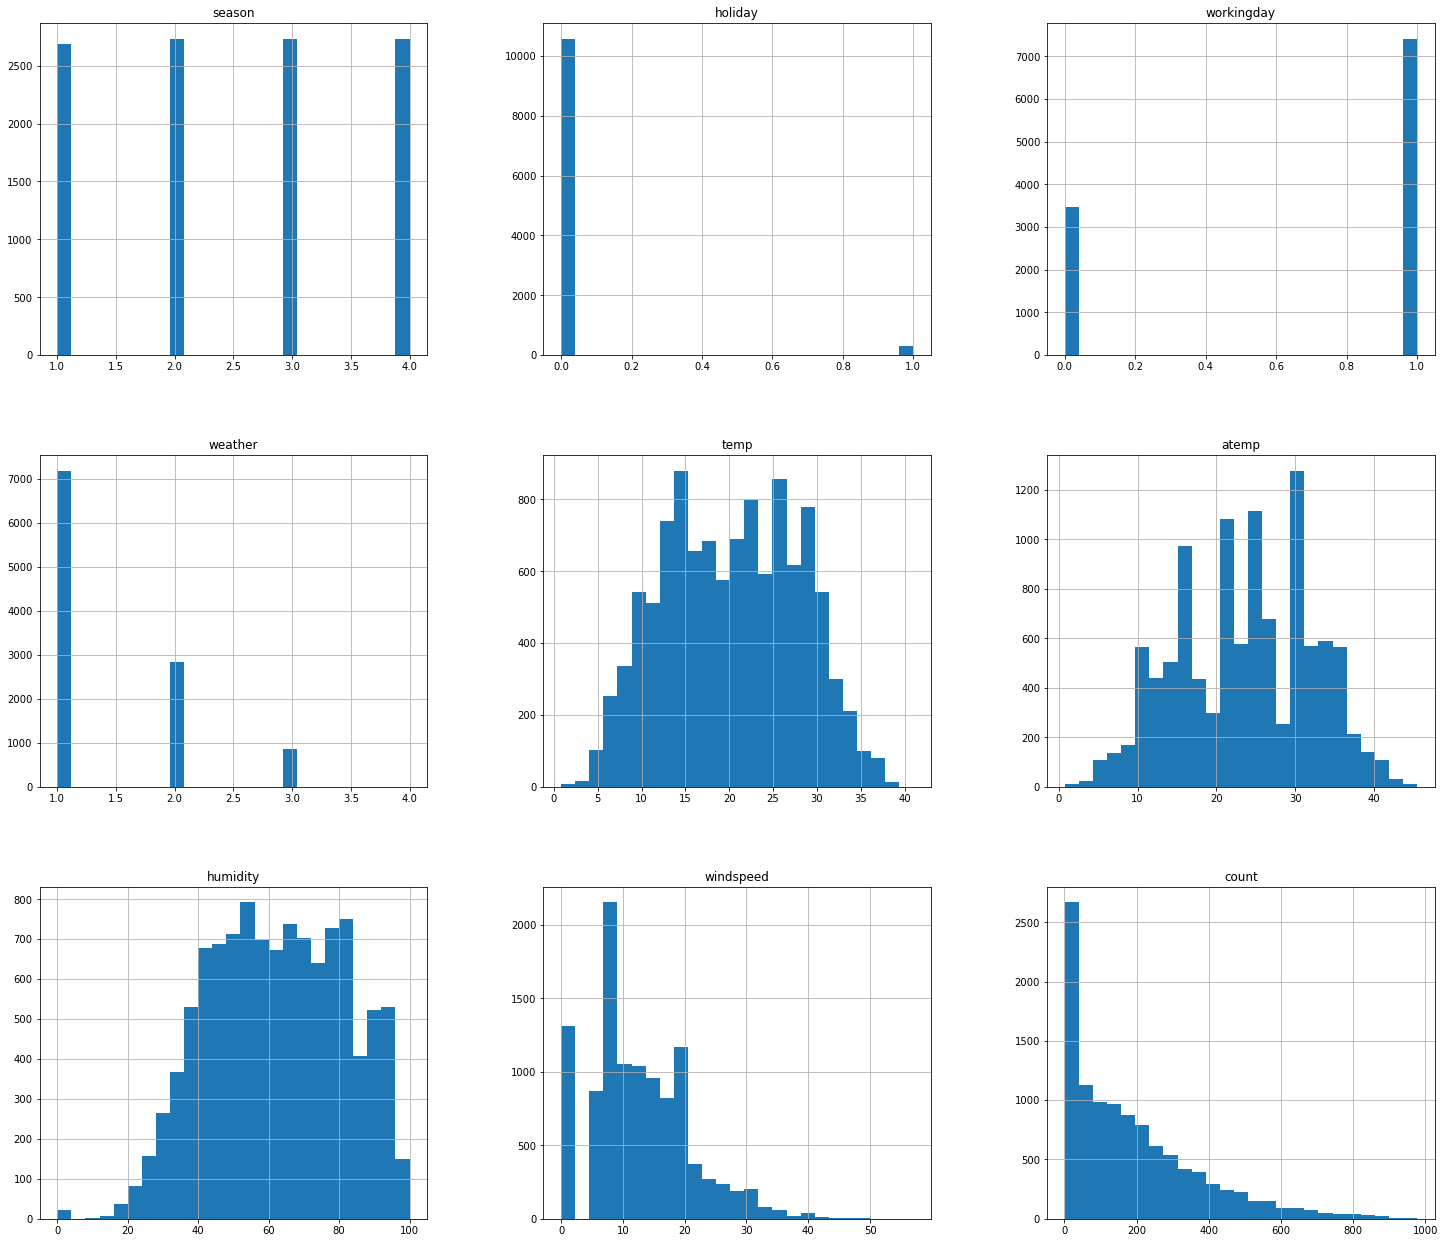

In [9]:
train.hist(figsize = (25,22), bins=25)

Check for outliers.

Text(0.5, 1.0, 'Count Distribution')

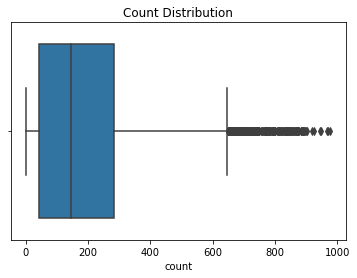

In [10]:
sns.boxplot(train['count']).set_title('Count Distribution')

We see that count has many outlier datapoints beyond the outer quartile.

Calculating quantiles to find and remove the outliers from the dataset.

In [11]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

season          2.0000
holiday         0.0000
workingday      1.0000
weather         1.0000
temp           12.3000
atemp          14.3950
humidity       30.0000
windspeed       9.9964
count         242.0000
dtype: float64


In [12]:
train.shape

(10886, 9)

In [13]:
# train_without_outliers = train[~((train < (Q1 - 1.5*IQR)) | (train > (Q3 + 1.5*IQR))).any(axis=1)]

We comment out the removal of outliers because previously doing so took out a whole category of datapoints (#4 Weather was entirely removed). Previously, we took out 842 datapoints, which is 7.7% of the data. But we have rerun the code with the outliers intact to preserve information.

In [14]:
data = train.append(test)

Plotting the first 250 rows of count (target) column to find the periodicity value (m) of the target column

<AxesSubplot:xlabel='datetime'>

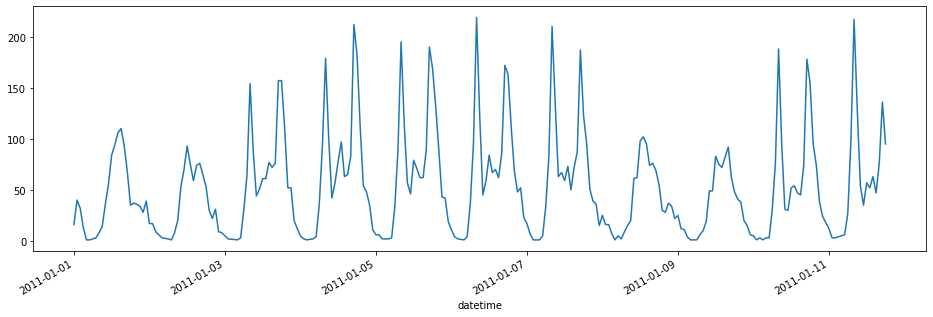

In [15]:
data['count'][0:250].plot(figsize=(16, 5))

We will work with a periodicity value (m) of 24, as it seems there are bi-montly differences in trend, as noted by the double crests per month for the 12 main crests in the graph above.

Text(0.5, 1.0, 'Count Distribution')

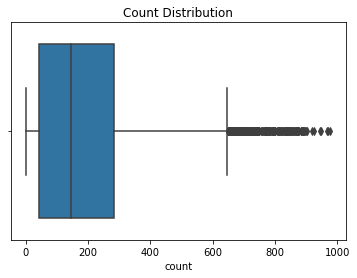

In [16]:
sns.boxplot(data['count']).set_title('Count Distribution')

We see that the number of outliers decreased significantly. 

Let's see the count distribution across season.

Text(0.5, 1.0, 'Count Distribution Across Season')

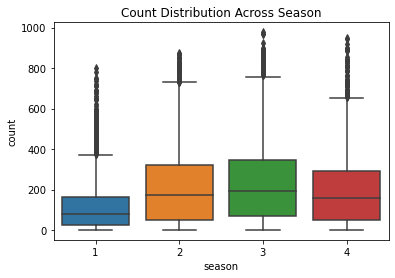

In [17]:
sns.boxplot(data['season'],data['count']).set_title('Count Distribution Across Season')

We see that season 1 (spring) has a significant drop in count. 

Let's see the count distribution across weather.

Text(0.5, 1.0, 'Count Distribution Across Weather')

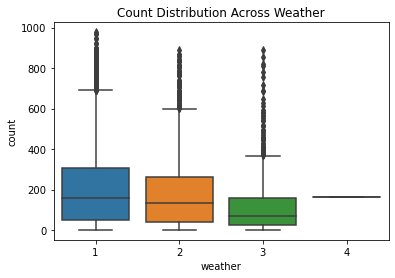

In [18]:
sns.boxplot(data['weather'],data['count']).set_title('Count Distribution Across Weather')

Hint: 
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

We see that the amount of rentals drop as it gets more rainy. 

Extract hour from datetime index.

In [19]:
data['hour'] = data.index.hour # hour in day
data['hour']

datetime
2011-01-01 00:00:00     0
2011-01-01 01:00:00     1
2011-01-01 02:00:00     2
2011-01-01 03:00:00     3
2011-01-01 04:00:00     4
                       ..
2012-12-31 19:00:00    19
2012-12-31 20:00:00    20
2012-12-31 21:00:00    21
2012-12-31 22:00:00    22
2012-12-31 23:00:00    23
Name: hour, Length: 17379, dtype: int64

Let's check out the count across hour of the day.

Text(0.5, 1.0, 'Count Distribution Across Hour')

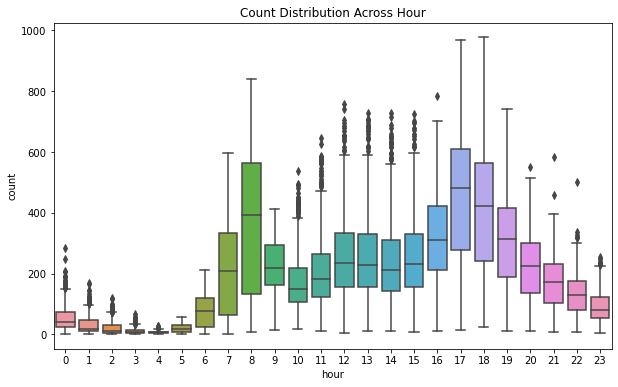

In [20]:
plt.figure(figsize = (10,6))
sns.boxplot(data['hour'],data['count']).set_title('Count Distribution Across Hour')

Peak hours are during commuting hours: between 7-8 in the morning, and 17-18 in the evening.

In [21]:
data.drop('hour',axis=1,inplace=True)

#### Finding the correlation value of target column (count) with other numerical variables present in the dataset

In [22]:
corr = data.corr()
corr['count'][:-1]

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
Name: count, dtype: float64

#### Finding if multi collinearity is present in the data, if it is then drop that particular column from the dataset.

Note: Multicollinearity occurs when there is a high correlation between the independent variables in the regression analysis which impacts the overall interpretation of the results.

The correlation between two variables can be measured with a correlation coefficient which can range between -1 to 1. If the value is 0, the two variables are independent and there is no correlation. If the measure is extremely close to one of these values, it indicates a linear relationship and highly correlated with each other.

In [23]:
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data = data.drop(data[to_drop], axis=1)

Process: We get the absolute value of the correlation matrix of the data. Then we create an upper triangle matrix with the same shape as the corr_matrix, and we select k=1 which corresponds to selecting the diagonals above the main diagonal of elements for the np.ones matrix. We set the 1s to Boolean and use this as conditional selection for the elements of the corr_matrix using the numpy.where() function which returns the indices of elements in an input array where the given condition is satisfied. Then we use the upper matrix of correlations as a filter to drop the columns which create multi-collinearity.

In [24]:
np.triu(np.ones(corr_matrix.shape), k=1)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count
datetime,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16.0
2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40.0
2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32.0
2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13.0
2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1.0


The column 'atemp' was removed from the dataset.

#### Plotting distribution plot for the variables having skewness.

Pandas .skew() function returns unbiased skew over requested axis Normalized by N-1. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

Bandwith kde_kws={'bw':0.1} is set to handle discontinous distribution.

In [26]:
data.skew()

season       -0.005416
holiday       5.638538
workingday   -0.785258
weather       1.228047
temp         -0.006021
humidity     -0.111287
windspeed     0.574905
count         1.242066
dtype: float64

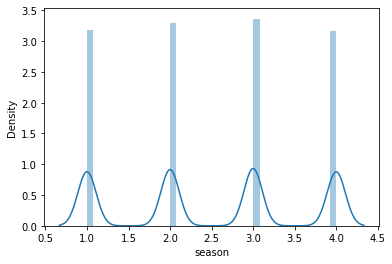

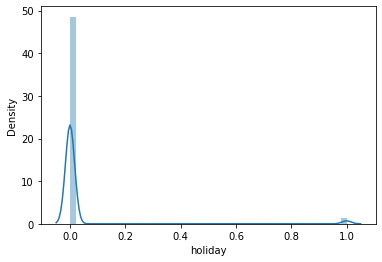

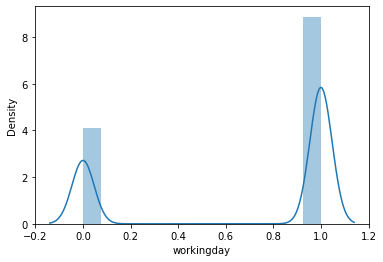

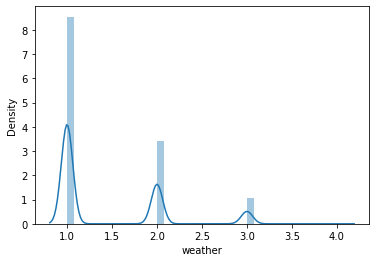

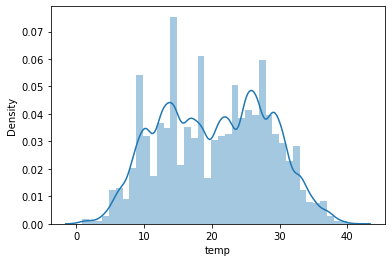

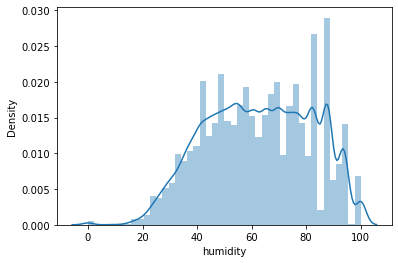

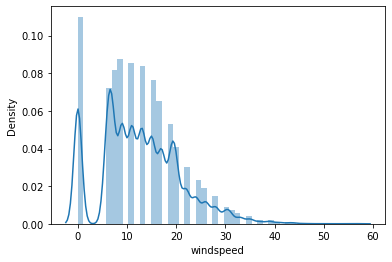

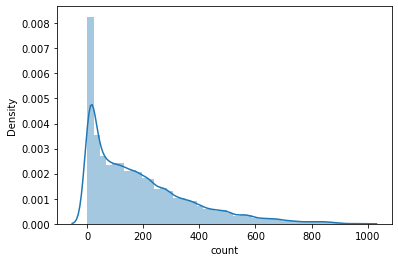

In [27]:
for i in (data.skew().index):
    plt.figure(i)
    sns.distplot(data[i], kde_kws={'bw':0.1})

Plotting scatter plot between "datetime index" and "count" column.

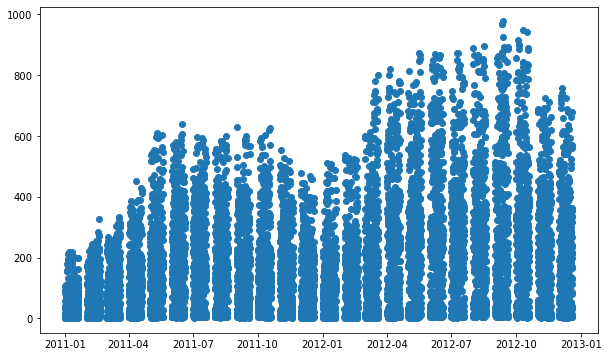

In [28]:
plt.figure(figsize=(10,6))
plt.scatter(data.index, data['count'])

Finding if there is any skewness present in the entire dataset and if it is then fixing it through the scipy.special.boxcox1p transformation. The Box-Cox transformation transforms our data so that it closely resembles a normal distribution. We take the numeric features and calculate its skewness. Then we select the elements that have an absolute value of skewness above 0.5 and apply the Box-Cox transformation to it. 

The Box-Cox transformation computed by boxcox1p is:

y = ((1+x)**lmbda - 1) / lmbda  if lmbda != 0

    log(1+x) if lmbda == 0
    
It returns nan if x < -1. Returns -inf if x == -1 and lmbda < 0.   

The scipy.stats.boxcox_normmax computes optimal Box-Cox transform parameter for input data.

In [29]:
def fixing_skewness(df):
    numeric_feats = df.dtypes[df.dtypes != object].index
    
    skew_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    
    high_skew = skew_feats[abs(skew_feats) > 0.5].index
    
    for i in high_skew:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))
#         print(i)
        
fixing_skewness(data)

The following function helps in reducing, if any overfitting is present in the dataset, that is if any variable in the dataset, contains only one value in 99.94 of the cases. 

We use a for loop to iterate over the dataframe and count how many times the variable occurs. Then we use an if statement to append those values which occur less than 0.06% of the time to the list "overfit". These are later dropped from the main dataframe "data".

In [30]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        count = df[i].value_counts()
        zero_index_value = count.iloc[0]
        
        if (((zero_index_value / len(df)) * 100) > 99.94):
            overfit.append(i)
            
    overfit = list(overfit)
    return overfit

In [31]:
#Finding the list of overfitted features using above user-defined function
overfitted_features = overfit_reducer(data)
#Dropping the overfitted columns from the final dataframes
data.drop(overfitted_features, axis=1, inplace=True)

In [32]:
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count
datetime,,,,,,,,
2011-01-01 00:00:00,1,0.0,0.0,0.720493,9.84,81,0.0,16.0
2011-01-01 01:00:00,1,0.0,0.0,0.720493,9.02,80,0.0,40.0
2011-01-01 02:00:00,1,0.0,0.0,0.720493,9.02,80,0.0,32.0
2011-01-01 03:00:00,1,0.0,0.0,0.720493,9.84,75,0.0,13.0
2011-01-01 04:00:00,1,0.0,0.0,0.720493,9.84,75,0.0,1.0


In [33]:
data.count().isnull()

season        False
holiday       False
workingday    False
weather       False
temp          False
humidity      False
windspeed     False
count         False
dtype: bool

In [34]:
data.dropna(axis=0,inplace=True)

The column 'holiday' was removed.

#### Run an ETS Decomposition

ETS stands for Error-Trend-Seasonality and is a model used for the time series decomposition. It decomposes the series into the error, trend and seasonality component.

We see from the Trend that there is a slight general increase in bike usage over time.

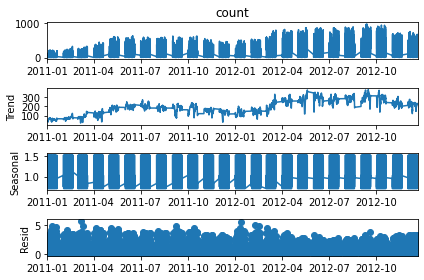

In [35]:
result = seasonal_decompose(data['count'], model='multiplicative', period=24)
result.plot();

#### Test for Stationarity

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

Using statsmodels.tsa.stattools.adfuller, the p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

In [36]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [37]:
adf_test(data['count'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.419976e+00
p-value                 1.801620e-08
# lags used             3.600000e+01
# observations          1.084900e+04
critical value (1%)    -3.430953e+00
critical value (5%)    -2.861806e+00
critical value (10%)   -2.566912e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We conclude that the data is stationary.

#### Run pmdarima.auto_arima to obtain recommended orders

We use pmdarima.auto_arima to select the best factors for the model of

SARIMAX(p,d,q)(P,D,Q)m.

(Note: We previously ran this parameter search tool and used its results successfully, but since it takes a lot of time to run, we have commented it out below. Anyway, we already have the numbers we need from it.)

In [38]:
# For SARIMA Orders we set seasonal=True and pass in an m value
# auto_arima(train_without_outliers['count'],seasonal=True,m=24, trace=True, n_jos=-1).summary()

Replacing the numerical values in Season and Weather column with the string values provided in the description of the dataset

In [39]:
data['season'] = data['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter' })
data['weather'] = data['weather'].replace({1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
                                        2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                        3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                        4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog' })

Creating dummies for object data type and storing the result in data_dummies dataframe

In [40]:
data_dummies = pd.get_dummies(data, drop_first=True)
data_dummies.columns

Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'count', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [41]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        10886 non-null  float64
 1   workingday     10886 non-null  float64
 2   weather        10886 non-null  float64
 3   temp           10886 non-null  float64
 4   humidity       10886 non-null  int64  
 5   windspeed      10886 non-null  float64
 6   count          10886 non-null  float64
 7   season_spring  10886 non-null  uint8  
 8   season_summer  10886 non-null  uint8  
 9   season_winter  10886 non-null  uint8  
dtypes: float64(6), int64(1), uint8(3)
memory usage: 712.3 KB


### Creating SARIMAX model

In [42]:
model = SARIMAX(data['count'], exog=data_dummies[:10887][['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'count',
       'season_spring', 'season_summer', 'season_winter']],
                                            order=(2, 1, 2), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False)

Fitting the model

In [43]:
results=model.fit()

Printing the summary of the result

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                10886
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood              115309.318
Date:                              Tue, 22 Jun 2021   AIC                        -230586.637
Time:                                      16:19:01   BIC                        -230469.914
Sample:                                           0   HQIC                       -230547.293
                                            - 10886                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
workingday    -2.371e-18   2.94e-23  -8.07e+04      0.000   -2.37e-18   -2.37e-18
weather        7.035e-14   1.44e-24   4.87e+10      0.000    7.03e-14    7.03e-14
temp           7.768e-15   2.42e-24   3.21e+09      0.000    7.77e-15    7.77e-15
humidity      -3.529e-16    7.4e-24  -4.77e+07      0.000   -3.53e-16   -3.53e-16
windspeed      3.643e-16   5.16e-24   7.05e+07      0.000    3.64e-16    3.64e-16
count             1.0000   2.17e-21    4.6e+20      0.000       1.000       1.000
season_spring  9.435e-14   2.28e-26   4.13e+12      0.000    9.44e-14    9.44e-14
season_summer  -1.25e-14   1.28e-26  -9.78e+11      0.000   -1.25e-14   -1.25e-14
season_winter  3.913e-14   7.65e-27   5.11e+12      0.000    3.91e-14    3.91e-14
ar.L1             0.5237   4.71e-25   1.11e+24      0.000       0.524       0.524
ar.L2            -0.3323    2.4e-24  -1.38e+23      0.000      -0.332      -0.332
ma.L1            -0.1720   8.54e-25  -2.02e+23      0.000      -0.172      -0.172
ma.L2            -0.0250   1.86e-24  -1.34e+22      0.000      -0.025      -0.025
ar.S.L24          0.7382   1.14e-22   6.47e+21      0.000       0.738       0.738
ma.S.L24         -0.2090   5.43e-23  -3.85e+21      0.000      -0.209      -0.209
sigma2             1e-10    1.9e-11      5.264      0.000    6.28e-11    1.37e-10
===================================================================================
Ljung-Box (L1) (Q):                1335.04   Jarque-Bera (JB):             18103.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+46. Standard errors may be unstable.
"""

#### Obtain forecasted values

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB


In [46]:
start = len(data)
end = len(data) + 10000

fcast = results.predict(start=start,end=end,exog=data_dummies[:10001][['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'count',
       'season_spring', 'season_summer', 'season_winter']]).rename('SARIMAX(1, 1, 1)x(2, 0, [1, 2], 2) Forecast')

Changing the data type of forecast to integer and dropping the index

In [47]:
# fcast = fcast.astype('int64')
# fcast = fcast.reset_index(drop=True)

In [48]:
fcast.index

RangeIndex(start=10886, stop=20887, step=1)

In [49]:
fcast.max()

976.9999999999992

In [50]:
fcast.min()

1.0000000000001248

<AxesSubplot:xlabel='datetime'>

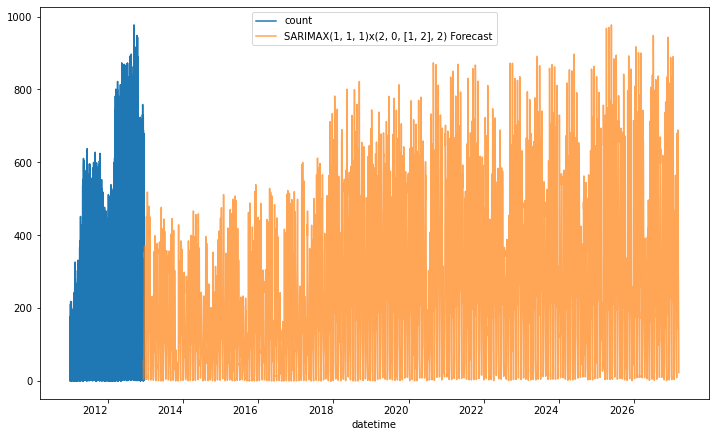

In [51]:
data['count'].plot(figsize=(12,8),legend=True)
fcast[4800:].plot(legend=True,alpha=0.7)

In [52]:
fcast.iloc[5000]

105.0000000000001

In [53]:
fcast.head(20)

10886     16.0
10887     40.0
10888     32.0
10889     13.0
10890      1.0
10891      1.0
10892      2.0
10893      3.0
10894      8.0
10895     14.0
10896     36.0
10897     56.0
10898     84.0
10899     94.0
10900    106.0
10901    110.0
10902     93.0
10903     67.0
10904     35.0
10905     37.0
Name: SARIMAX(1, 1, 1)x(2, 0, [1, 2], 2) Forecast, dtype: float64

#### Serializing

In [54]:
import pickle

In [55]:
with open('model_pickle','wb') as f:
    pickle.dump(model,f)

In [58]:
# with open ('model_pickle','rb') as f:
  #  model = pickle.load(f)

In [56]:
with open('fcast_pickle','wb') as g:
    pickle.dump(fcast,g)

In [59]:
# with open ('fcast_pickle','rb') as g:
  #  fcast = pickle.load(g)

### Thank you!